Inputs to this analysis are:

In [23]:
# The tdb to analyze
tdb_fn = "/Users/english/code/references/hprc_105.tdb/"

# The results of tdb query len_poly_score
len_poly_fn = "../hprc_105_len_poly_score.txt"

# The results of Fst query by allele length
fst_fn = "../result_fst.tsv"

# The metadata with "Sample name" and "Superpopulation code"
meta_fn = "/Users/english/code/references/hprc_105.tdb/igsr_samples.tsv"

Now we combine the len_poly and fst tables using the locus position as the key

In [2]:
import pandas as pd

lp = pd.read_csv("../hprc_105_len_poly_score.txt", sep='\t')
fst = pd.read_csv("../result_fst.tsv", sep='\t')

lp.set_index(['chrom', 'start', 'end'], inplace=True)
fst.set_index(['chrom', 'start', 'end'], inplace=True)

fst['len_poly_score'] = lp['len_poly_score']
fst.head()

Unnamed: 0  is_ref   AC        AF  AC_EAS  AC_AMR  AC_AFR  \
chrom start end                                                                
chr1  16682 16774           0    True  161  0.856383      16      28      26   
            16774           1   False   27  0.143617       4       8       9   
      19275 19473           2    True  178  0.946809      16      28      26   
            19473           3   False   10  0.053191       0       2       7   
      20798 20893           4    True  146  0.776596      16      28      26   

                   AC_SAS       fst  len_poly_score  
chrom start end                                      
chr1  16682 16774      24  0.000000        1.904762  
            16774       6  0.003152        1.904762  
      19275 19473      24  0.000000        1.904762  
            19473       1  0.053089        1.904762  
      20798 20893      24  0.000000        1.904762

The first set of candidate loci will be those with an allele having Fst ≥ 0.20 and length polymorphism score above 20

In [17]:
# Candidate loci
keep_fs = fst['fst'] >= 0.20
print(keep_fs.sum(), 'fst alleles')

keep_lp = fst['len_poly_score'] >= 20
print(keep_lp.sum(), 'lpoly loci')

keep_both = keep_fs & keep_lp

candidate_alleles = fst[keep_both]
candidate_loci = candidate_alleles.reset_index()[['chrom', 'start', 'end']].drop_duplicates()

print(len(candidate_alleles), 'total alleles')
print(len(candidate_loci), 'total loci')

7277 fst alleles
59428 lpoly loci
14 total alleles
14 total loci


In this case, each locus had 1 allele with an fst passing the threshold.

Now, we fetch the locus ids. Instead of loading the entire tdb, we just load the locus table.

In [21]:
import os
import tdb

loci = pd.read_parquet(os.path.join(tdb_fn, 'locus.pq'))

# turn the candidate_loci into an index
idx_candidate_loci = candidate_loci.set_index(['chrom', 'start', 'end']).index
loci.set_index(['chrom', 'start', 'end'], inplace=True)

candidate_loci_ids = loci[loci.index.isin(idx_candidate_loci)]['LocusID']

data = tdb.load_tdb("/Users/english/code/references/hprc_105.tdb",
                    lfilters=[('LocusID', 'in', candidate_loci_ids)])

We want to plot the PCA, but first we need to make data for the PCA by seeing what alleles are in each sample.


In [96]:
# We'll build a table with every row having the unique by length allele every column being 
# 0 if the allele isn't observed in the sample or the allele length observed
allele_length_lookup = data['allele'].set_index(['LocusID', 'allele_number'])[['allele_length']]
keys = ["LocusID", 'allele_length']
allele_samples = (data['allele'][keys]
                      .sort_values(by=keys)
                      .drop_duplicates()
                      .set_index(keys))

all_lengths = []
for i, sample in enumerate(data['sample']):
    # Setup the sample table index
    m_samp = data['sample'][sample].set_index(['LocusID', 'allele_number'])
    m_samp['allele_length'] = allele_length_lookup['allele_length']
    m_samp = m_samp.reset_index().set_index(['LocusID', 'allele_length'])
    # Just mark 0/1 for present /absent
    allele_samples[sample] = allele_samples.index.isin(m_samp.index).astype(int)
    # de-fragment the frame every once in a while. Useful for big tables
    if i % 50 == 0:
        allele_samples = allele_samples.copy()

# We'll make a lookup of allele lengths
all_lengths = allele_samples.reset_index()['allele_length'].values.reshape((len(allele_samples), 1))

allele_samples = allele_samples * all_lengths
allele_samples

HG002  HG03825  HG02668  HG02738  HG00609  HG02293  \
LocusID allele_length                                                       
132443  74                 0        0        0        0        0        0   
        78                 0        0       78        0        0        0   
        80                 0        0       80        0        0        0   
        81                 0        0        0        0        0        0   
        82                82        0        0        0        0        0   
...                      ...      ...      ...      ...      ...      ...   
914869  132                0        0      132        0        0        0   
        133                0        0        0        0      133        0   
        134                0        0        0        0        0        0   
        136                0        0        0        0        0        0   
        137                0        0        0        0      137        0   

                       HG02027  HG006  HG02300  HG00738  ...  HG005  HG02055  \
LocusID allele_length                                    ...                   
132443  74                   0      0        0        0  ...      0        0   
        78                   0      0        0        0  ...      0        0   
        80                   0      0        0        0  ...      0        0   
        81                   0      0        0        0  ...      0        0   
        82                   0      0        0        0  ...      0        0   
...                        ...    ...      ...      ...  ...    ...      ...   
914869  132                  0      0        0        0  ...      0        0   
        133                  0      0        0        0  ...      0        0   
        134                  0      0        0        0  ...      0        0   
        136                  0      0        0        0  ...      0        0   
        137                  0      0        0        0  ...      0        0   

                       HG02004  HG02818  HG03816  HG01952  HG01884  HG03453  \
LocusID allele_length                                                         
132443  74                   0        0        0        0        0        0   
        78                   0        0        0        0        0        0   
        80                   0        0        0        0       80       80   
        81                   0        0        0        0        0        0   
        82                   0       82        0        0        0        0   
...                        ...      ...      ...      ...      ...      ...   
914869  132                  0        0        0        0        0        0   
        133                  0        0        0        0        0        0   
        134                  0        0        0        0        0        0   
        136                  0        0        0        0      136        0   
        137                  0        0        0        0        0        0   

                       HG01358  HG02071  
LocusID allele_length                    
132443  74                   0        0  
        78                   0        0  
        80                   0        0  
        81                   0        0  
        82                   0        0  
...                        ...      ...  
914869  132                  0        0  
        133                  0        0  
        134                  0        0  
        136                  0        0  
        137                  0        0  

[495 rows x 105 columns]

In [32]:
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Method to plot PCA
def plot_pca(alleles, meta, title, out_fn):
    pca = PCA(n_components=2)
    values = alleles.values.T
    X_r = pca.fit(values).transform(values)

    m_X = pd.DataFrame(X_r, columns=["PC1", "PC2"])
    m_X['sample'] = alleles.columns

    # Add Population information for the plot
    slookup = dict(zip(meta["Sample name"], meta["Superpopulation code"]))
    m_X['Super Pop'] = m_X['sample'].map(slookup).fillna('UNK')

    pc1, pc2 = pca.explained_variance_ratio_
    pc1 = round(pc1*100, 1)
    pc2 = round(pc2*100, 1)

    order = sorted(m_X['Super Pop'].unique())
    p = sb.scatterplot(data=m_X, x="PC1", y="PC2", hue="Super Pop",
                       hue_order=order)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    _ = p.set(title=title, xlabel=f"PC1 ({pc1}%)", ylabel=f"PC2  ({pc2}%)")
    plt.savefig(out_fn)

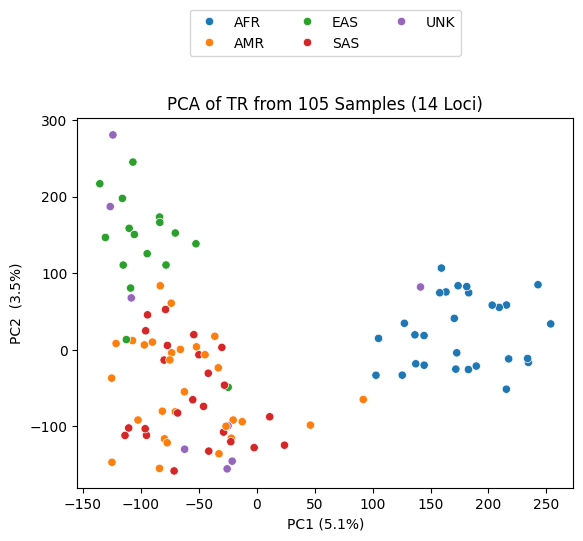

In [99]:
meta = pd.read_csv(meta_fn, sep='\t')

title = f"PCA of TR from {len(data['sample'])} Samples ({len(candidate_loci_ids)} Loci)"
plot_pca(allele_samples, meta, title, "PopLoci_14.png")

Another thing we can do is 'test' how well these loci can classify a sample as part of a population. To do this, we'll use a k-nearest neighbors algorithm. Again, we have to first setup our data. Here we want every row to be a sample and every column to be our locus of interest

In [135]:
allele_length_lookup = data['allele'].set_index(['LocusID', 'allele_number'])[['allele_length']]
metadata = meta.set_index(['Sample name'])
known_rows = []
unk_rows = []

known_pops = []
unk_pops = []

known_samps = []
unk_samps = []

for samp, table in data["sample"].items():
    view = table.set_index(["LocusID", "allele_number"])
    view["allele_length"] = allele_length_lookup
    
    if samp not in metadata.index:
        unk_pops.append('UNK')
        unk_rows.append(view.iloc[::2]["allele_length"].reset_index(drop=True))
        unk_samps.append(samp)
    else:
        known_pops.extend([metadata.loc[samp]["Superpopulation code"]])
        known_rows.append(view.iloc[::2]["allele_length"].reset_index(drop=True))
        known_samps.append(samp)
        
# And we'll separate our unknown from known sets
unknown_data = pd.concat(unk_rows, axis=1).T
unknown_data['Population'] = unk_pops
unknown_data['Sample'] = unk_samps
unknown_data.reset_index(drop=True, inplace=True)

known_data = pd.concat(known_rows, axis=1).T
known_data['Population'] = known_pops
known_data['Sample'] = known_samps
known_data.reset_index(drop=True, inplace=True)

In [136]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
known_data_scaled = scaler.fit_transform(known_data.drop(columns=['Population', "Sample"]))
unknown_data_scaled = scaler.transform(unknown_data.drop(columns=['Population', "Sample"]))  # Use the same scaler

# Split known data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    known_data_scaled, known_data['Population'], test_size=0.20, random_state=42
)

# Train a K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')  # You may need to tune this parameter
knn.fit(X_train, y_train)

# Evaluate the model
y_pred = knn.predict(X_test)


# Predict populations for unknown samples
unknown_predictions = knn.predict(unknown_data_scaled)

# Add predictions to the unknown dataset
unknown_data['Population'] = unknown_predictions

print()

print(unknown_data)

[[3 0 0 0]
 [1 5 0 1]
 [0 3 1 0]
 [0 3 0 3]]
              precision    recall  f1-score   support

         AFR       0.75      1.00      0.86         3
         AMR       0.45      0.71      0.56         7
         EAS       1.00      0.25      0.40         4
         SAS       0.75      0.50      0.60         6

    accuracy                           0.60        20
   macro avg       0.74      0.62      0.60        20
weighted avg       0.70      0.60      0.58        20

     0    1    2    3    4   5    6    7    8    9   10   11   12   13  \
0   82   77  175   74   74  81  132   82  113   94   84   99   76  127   
1   88   85  180   72   74  97  123   81  100   94   76  109  103  103   
2   84   91  157   71   89  80  123   79   94  104   76  108  103  103   
3  110   77  168   74   73  70  142   81  115   94   76   96   77  120   
4   86   81  135   95   67  64  123   69   88   76   76   94   77  107   
5   84   85  175   98   84  94  122   81  117   84   83  109  103  118   
6 

In [146]:
# Confusion matrix
pops = ['AFR', 'AMR', 'EAS', 'SAS']
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=pops), index=pops, columns=pops)

,AFR,AMR,EAS,SAS
AFR,3,0,0,0
AMR,1,5,0,1
EAS,0,3,1,0
SAS,0,3,0,3
